In [36]:
import torch
import numpy as np

In [37]:
def hz2bark_torch(f):
        """ Usage: Bark=hz2bark(f)
            f    : (ndarray)    Array containing frequencies in Hz.
        Returns  :
            Brk  : (ndarray)    Array containing Bark scaled values.
        """
        if not torch.is_tensor(f):
          f = torch.tensor(f)

        Brk = 6. * torch.arcsinh(f/600.)                                           
        return Brk

In [38]:
def bark2hz_torch(Brk):
        """ Usage:
        Hz=bark2hs(Brk)
        Args     :
            Brk  : (ndarray)    Array containing Bark scaled values.
        Returns  :
            Fhz  : (ndarray)    Array containing frequencies in Hz.
        """
        if not torch.is_tensor(Brk):
          Brk = torch.tensor(Brk)
        Fhz = 600. * torch.sinh(Brk/6.)
        return Fhz

In [39]:
def mapping2barkmat_torch(fs, nfilts,nfft):
  #Constructing mapping matrix W which has 1's for each Bark subband, and 0's else
  #usage: W=mapping2barkmat(fs, nfilts,nfft)  
  #arguments: fs: sampling frequency
  #nfilts: number of subbands in Bark domain
  #nfft: number of subbands in fft
  maxbark=hz2bark_torch(fs/2) #upper end of our Bark scale:22 Bark at 16 kHz
  nfreqs=nfft/2; step_bark = maxbark/(nfilts-1)
  binbark = hz2bark_torch(torch.linspace(0,(nfft/2),(nfft//2)+1)*fs/nfft)
  W = torch.zeros((nfilts, nfft))
  for i in range(nfilts):
     W[i,0:int(nfft/2)+1] = (torch.round(binbark/step_bark)== i)
  return W

In [40]:
def mapping2bark_torch(mX,W,nfft):
  #Maps (warps) magnitude spectrum vector mX from DFT to the Bark scale
  #arguments: mX: magnitude spectrum from fft
  #W: mapping matrix from function mapping2barkmat
  #nfft: : number of subbands in fft
  #returns: mXbark, magnitude mapped to the Bark scale
  nfreqs=int(nfft/2)
  #Here is the actual mapping, suming up powers and conv. back to Voltages:
  mXbark = (torch.matmul( torch.abs(mX[:nfreqs])**2.0, W[:, :nfreqs].T))**(0.5)
  return mXbark

In [41]:
def mappingfrombarkmat_torch(W,nfft):
  #Constructing inverse mapping matrix W_inv from matrix W for mapping back from bark scale
  #usuage: W_inv=mappingfrombarkmat(Wnfft)
  #argument: W: mapping matrix from function mapping2barkmat
  #nfft: : number of subbands in fft
  nfreqs=int(nfft/2)
  W_inv= torch.matmul(torch.diag((1.0/(torch.sum(W,1)+1e-6))**0.5), W[:,0:nfreqs + 1]).T
  return W_inv

In [42]:
def mappingfrombark_torch(mTbark,W_inv,nfft):
  #usage: mT=mappingfrombark(mTbark,W_inv,nfft)
  #Maps (warps) magnitude spectrum vector mTbark in the Bark scale
  # back to the linear scale
  #arguments:
  #mTbark: masking threshold in the Bark domain
  #W_inv : inverse mapping matrix W_inv from matrix W for mapping back from bark scale
  #nfft: : number of subbands in fft
  #returns: mT, masking threshold in the linear scale
  nfreqs=int(nfft/2)
  mT = torch.matmul(mTbark, W_inv[:, :nfreqs].T.float())
  return mT

In [43]:
def f_SP_dB_torch(maxfreq,nfilts):
   #usage: spreadingfunctionmatdB=f_SP_dB(maxfreq,nfilts)
   #computes the spreading function protoype, in the Bark scale.
   #Arguments: maxfreq: half the sampling freqency
   #nfilts: Number of subbands in the Bark domain, for instance 64   
   maxbark=hz2bark_torch(maxfreq) #upper end of our Bark scale:22 Bark at 16 kHz
   #Number of our Bark scale bands over this range: nfilts=64
   spreadingfunctionBarkdB=torch.zeros(2*nfilts)
   #Spreading function prototype, "nfilts" bands for lower slope 
   spreadingfunctionBarkdB[0:nfilts]=torch.linspace(-maxbark*27,-8,nfilts)-23.5
   #"nfilts" bands for upper slope:
   spreadingfunctionBarkdB[nfilts:2*nfilts]=torch.linspace(0,-maxbark*12.0,nfilts)-23.5
   return spreadingfunctionBarkdB

In [44]:
def spreadingfunctionmat_torch(spreadingfunctionBarkdB,alpha,nfilts):
   #Turns the spreading prototype function into a matrix of shifted versions.
   #Convert from dB to "voltage" and include alpha exponent
   #nfilts: Number of subbands in the Bark domain, for instance 64  
   spreadingfunctionBarkVoltage=10.0**(spreadingfunctionBarkdB/20.0*alpha)
   #Spreading functions for all bark scale bands in a matrix:
   spreadingfuncmatrix=torch.zeros((nfilts,nfilts))
   for k in range(nfilts):
      spreadingfuncmatrix[k,:]=spreadingfunctionBarkVoltage[(nfilts-k):(2*nfilts-k)]
   return spreadingfuncmatrix

In [45]:
def maskingThresholdBark_torch(mXbark,spreadingfuncmatrix,alpha,fs,nfilts): 
  #Computes the masking threshold on the Bark scale with non-linear superposition
  #usage: mTbark=maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha)
  #Arg: mXbark: magnitude of FFT spectrum, on the Bark scale
  #spreadingfuncmatrix: spreading function matrix from function spreadingfunctionmat
  #alpha: exponent for non-linear superposition (eg. 0.6), 
  #fs: sampling freq., nfilts: number of Bark subbands
  #nfilts: Number of subbands in the Bark domain, for instance 64  
  #Returns: mTbark: the resulting Masking Threshold on the Bark scale 
  
  #Compute the non-linear superposition:
  mTbark=torch.matmul(mXbark**alpha, spreadingfuncmatrix**alpha)
  #apply the inverse exponent to the result:
  mTbark=mTbark**(1.0/alpha)
  #Threshold in quiet:
  maxfreq=fs/2.0
  maxbark=hz2bark_torch(maxfreq)
  step_bark = maxbark/(nfilts-1)
  barks=torch.arange(0,nfilts)*step_bark
  #convert the bark subband frequencies to Hz:
  f=bark2hz_torch(barks)+1e-6
  #Threshold of quiet in the Bark subbands in dB:
  LTQ=torch.clip((3.64*(f/1000.)**-0.8 -6.5*torch.exp(-0.6*(f/1000.-3.3)**2.)
      +1e-3*((f/1000.)**4.)),-20,120)
  #Maximum of spreading functions and hearing threshold in quiet:
  a = mTbark
  b = 10.0**((LTQ-60)/20)
  mTbark=torch.max(a,b)
  return mTbark

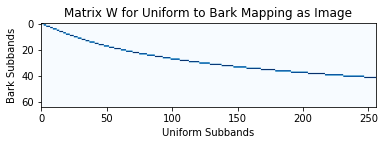

In [46]:
import matplotlib.pyplot as plt

fs=32000  # sampling frequency of audio signal
maxfreq=fs/2
alpha=0.8  #Exponent for non-linear superposition of spreading functions
nfilts=64  #number of subbands in the bark domain
nfft=2048  #number of fft subbands

W=mapping2barkmat_torch(fs,nfilts,nfft)
plt.imshow(W[:,:256].numpy(),cmap='Blues')
plt.title('Matrix W for Uniform to Bark Mapping as Image')
plt.xlabel('Uniform Subbands')
plt.ylabel('Bark Subbands')
plt.show()

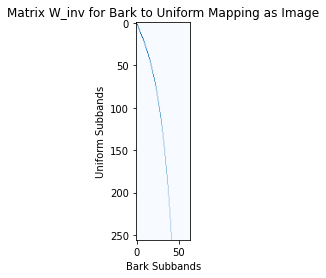

In [47]:
W_inv=mappingfrombarkmat_torch(W,nfft)
plt.imshow(W_inv[:256,:].numpy(),cmap='Blues')
plt.title('Matrix W_inv for Bark to Uniform Mapping as Image')
plt.xlabel('Bark Subbands')
plt.ylabel('Uniform Subbands')
plt.show()

maxfreq= 16000.0 maxbark= tensor(23.8615)


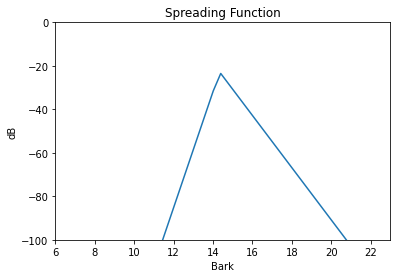

In [48]:
spreadingfunctionBarkdB=f_SP_dB_torch(maxfreq,nfilts)
#x-axis: maxbark Bark in nfilts steps:
maxbark=hz2bark_torch(maxfreq)
print("maxfreq=", maxfreq, "maxbark=", maxbark)
bark=torch.linspace(0,maxbark,nfilts)
#The prototype over "nfilt" bands or 22 Bark, its center 
#shifted down to 22-26/nfilts*22=13 Bark:
plt.plot(bark.numpy(),spreadingfunctionBarkdB[26:(26+nfilts)].numpy())
plt.axis([6,23,-100,0])
plt.xlabel('Bark')
plt.ylabel('dB')
plt.title('Spreading Function')
plt.show()

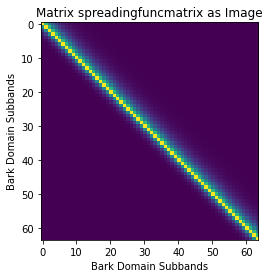

In [49]:
spreadingfuncmatrix=spreadingfunctionmat_torch(spreadingfunctionBarkdB,alpha, nfilts)
plt.imshow(spreadingfuncmatrix.numpy())
plt.title('Matrix spreadingfuncmatrix as Image')
plt.xlabel('Bark Domain Subbands')
plt.ylabel('Bark Domain Subbands')
plt.show()

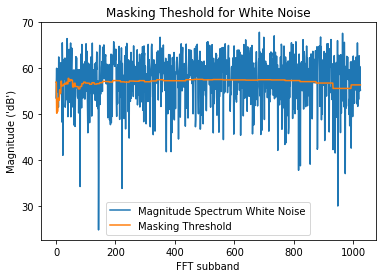

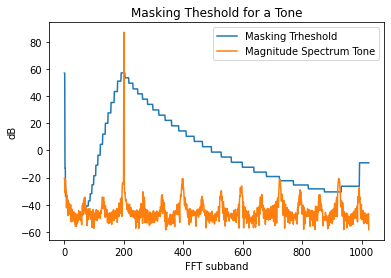

"\n  y=zeros((1025,3))\n  y[0,0]=1\n  t,x=scipy.signal.istft(y,window='boxcar')\n  plot(x)\n  #yields rectangle with amplitude 1/2, for orthonormality it would be sqrt(2/N) with overlap, \n  #hence we need a factor sqrt(2/N)*2 for the synthesis, and sqrt(N/2)/2 for the analysis\n  #for othogonality.\n  #Hence it needs factor sqrt(N/2)/2/windowpowerpersample, hence for Hann Window:\n  #y=y*sqrt(2048/2)/2/0.375\n  "

In [50]:
#-Testing-----------------------------------------
#A test magnitude spectrum:
# White noise:
x=torch.randn(32000)*1000
x.requires_grad=True
import IPython.display as ipd
display(ipd.Audio(x.detach().numpy(),rate=fs))
  
mX=torch.abs(torch.fft.fft(x[0:2048],norm='ortho'))[0:1025]
mXbark=mapping2bark_torch(mX,W,nfft)
#Compute the masking threshold in the Bark domain:  
mTbark=maskingThresholdBark_torch(mXbark,spreadingfuncmatrix,alpha,fs,nfilts)
#Massking threshold in the original frequency domain
mT=mappingfrombark_torch(mTbark,W_inv,nfft)
plt.plot(20*np.log10(mX.detach().numpy()+1e-3))
plt.plot(20*np.log10(mT.detach().numpy()+1e-3))
plt.title('Masking Theshold for White Noise')
plt.legend(('Magnitude Spectrum White Noise','Masking Threshold'))
plt.xlabel('FFT subband')
plt.ylabel("Magnitude ('dB')")
plt.show()
#----------------------------------------------
#A test magnitude spectrum, an idealized tone in one subband:
#tone at FFT band 200:
x=torch.sin(2*torch.pi/nfft*200*torch.arange(32000))*1000
x.requires_grad=True
import IPython.display as ipd
display(ipd.Audio(x.detach().numpy(),rate=fs))
  
mX=torch.abs(torch.fft.fft(x[0:2048],norm='ortho'))[0:1025]
#Compute the masking threshold in the Bark domain:  
mXbark=mapping2bark_torch(mX,W,nfft)
mTbark=maskingThresholdBark_torch(mXbark,spreadingfuncmatrix,alpha,fs,nfilts)
mT=mappingfrombark_torch(mTbark,W_inv,nfft)
plt.plot(20*np.log10(mT.detach().numpy()+1e-3))
plt.title('Masking Theshold for a Tone')
plt.plot(20*np.log10(mX.detach().numpy()+1e-3))
plt.legend(('Masking Trheshold', 'Magnitude Spectrum Tone'))
plt.xlabel('FFT subband')
plt.ylabel("dB")
plt.show()
  
  #stft, norm='ortho':
  #import scipy.signal
  #f,t,y=scipy.signal.stft(x,fs=32000,nperseg=2048)
  #make it orthonormal for Parsevals Theorem:
  #Hann window power per sample: 0.375
  #y=y*sqrt(2048/2)/2/0.375
  #plot(y[:,1])
  #plot(mX)
  
"""
  y=zeros((1025,3))
  y[0,0]=1
  t,x=scipy.signal.istft(y,window='boxcar')
  plot(x)
  #yields rectangle with amplitude 1/2, for orthonormality it would be sqrt(2/N) with overlap, 
  #hence we need a factor sqrt(2/N)*2 for the synthesis, and sqrt(N/2)/2 for the analysis
  #for othogonality.
  #Hence it needs factor sqrt(N/2)/2/windowpowerpersample, hence for Hann Window:
  #y=y*sqrt(2048/2)/2/0.375
  """

In [ ]:
# Test to Check Differentiability 

In [51]:
# -*- coding: utf-8 -*-
import torch
import math
import random


class Polynomial3(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))
        self.c = torch.nn.Parameter(torch.randn(()))
        self.d = torch.nn.Parameter(torch.randn(()))


    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x_pred = self.a + self.b * x + self.c * x ** 2 + self.d * x ** 3
        mX=torch.abs(torch.fft.fft(x_pred[0:2048],norm='ortho'))[0:1025]
        mXbark=mapping2bark_torch(mX,W,nfft)
        #Compute the masking threshold in the Bark domain:  
        mTbark=maskingThresholdBark_torch(mXbark,spreadingfuncmatrix,alpha,fs,nfilts)
        #Massking threshold in the original frequency domain
        mT=mappingfrombark_torch(mTbark,W_inv,nfft)
        return x_pred , mT

    def string(self):
        """
        Just like any class in Python, you can also define custom method on PyTorch modules
        """
        return f'y = {self.a.item()} + {self.b.item()} x + {self.c.item()} x^2 + {self.d.item()} x^3'


# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 4000)
x.requires_grad=True
y = torch.sin(x)


y_mX=torch.abs(torch.fft.fft(y[0:2048],norm='ortho'))[0:1025]
y_mXbark=mapping2bark_torch(y_mX,W,nfft)
#Compute the masking threshold in the Bark domain:  
y_mTbark=maskingThresholdBark_torch(y_mXbark,spreadingfuncmatrix,alpha,fs,nfilts)
#Massking threshold in the original frequency domain
y_mT=mappingfrombark_torch(y_mTbark,W_inv,nfft)

# Construct our model by instantiating the class defined above
model = Polynomial3()

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters (defined 
# with torch.nn.Parameter) which are members of the model.
criterion1 = torch.nn.MSELoss(reduction='sum')
criterion2 = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)
for t in range(2000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred, y_pred_mT = model(x)

    # Compute and print loss
    loss = criterion1(y_pred,y) + 0.001*criterion2(20*torch.log10(y_pred_mT+1e-3),20*torch.log10(y_mT+1e-3) )
    
    if t % 100 == 99:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward(retain_graph=True )
    optimizer.step()

print(f'Result: {model.string()}')

99 1655.2860107421875
199 646.021484375
299 492.5227355957031
399 633.917724609375
499 160.13645935058594
599 161.38998413085938
699 168.968505859375
799 174.26327514648438
899 176.56723022460938
999 177.7803955078125
1099 178.1064453125
1199 178.05612182617188
1299 177.9119110107422
1399 177.77536010742188
1499 177.6722412109375
1599 177.60118103027344
1699 177.5546875
1799 177.52476501464844
1899 177.50607299804688
1999 177.49468994140625
Result: y = 0.002446776954457164 + 0.8562199473381042 x + -0.002225710079073906 x^2 + -0.08278863877058029 x^3


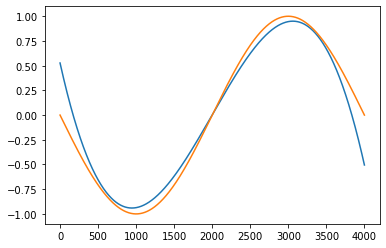

In [52]:
plt.figure()
plt.plot(y_pred.detach().numpy())
plt.plot(y.detach().numpy())

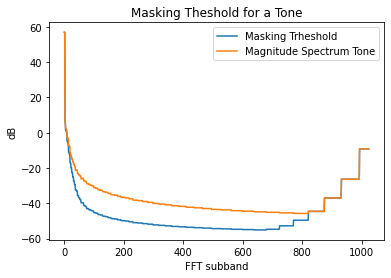

In [53]:
plt.figure()
plt.plot(20*np.log10(y_mT.detach().numpy()+1e-3))
plt.title('Masking Theshold for a Tone')
plt.plot(20*np.log10(y_pred_mT.detach().numpy()+1e-3))
plt.legend(('Masking Trheshold', 'Magnitude Spectrum Tone'))
plt.xlabel('FFT subband')
plt.ylabel("dB")
plt.show()